# XGBoost

In [1]:
# 환경설정
import matplotlib.pyplot as plt 
# 한글출력
plt.rcParams['font.family'] = 'Malgun Gothic' #  Windows 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 가져오기
import pandas as pd

train = pd.read_csv("train.csv")
train.head(1)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0


In [3]:
test = pd.read_csv("test.csv")
test.head(1)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8


In [4]:
train.isnull().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [5]:
sex_encoded = pd.get_dummies(train['Sex'], prefix='Sex')
sex_encoded

train = pd.concat([train, sex_encoded], axis=1)
train.head(1)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Sex_female,Sex_male
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,False,True


In [6]:
train = train.drop('Sex', axis=1)
train.head(1)

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Sex_female,Sex_male
0,0,36,189.0,82.0,26.0,101.0,41.0,150.0,False,True


In [7]:
from sklearn.preprocessing import StandardScaler
import sklearn
import numpy as np

print(sklearn.__version__)
print(np.__version__)

1.6.1
2.2.6


In [8]:
numeric_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
train[numeric_features].head(1)

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,36,189.0,82.0,26.0,101.0,41.0


In [9]:
# RMSLE 평가지표를 따라가기 위해서 로그변환
y = np.log1p(train['Calories'])  # log(1+x) == log1p(), Target

# 특성 스케일링 
scaler = StandardScaler()
numeric_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
X = train[numeric_features]
X_scaled = scaler.fit_transform(X)
X_scaled[0]

# 결과 : 위에 있는 표에 있는 값의 단위를 맞춰준 거랍니다. 

array([-0.3571921 ,  1.11523482,  0.49020109,  1.2663241 ,  0.58371421,
        1.23577241])

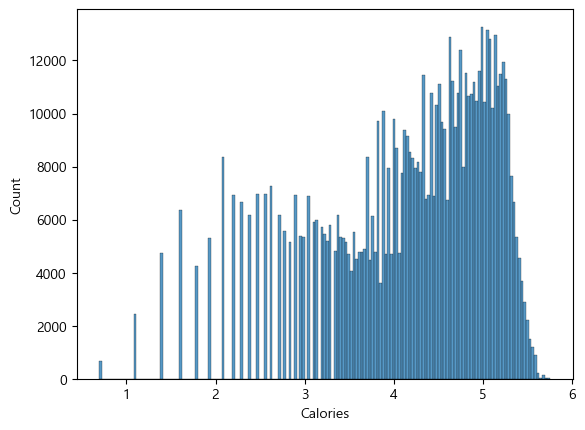

In [10]:
# y, 칼로리 분포 확인하려고 시각화
import matplotlib.pyplot as plt
import seaborn as sns

df = y.to_frame()
fig, ax = plt.subplots()
sns.histplot(data=df, x='Calories')
plt.show()

In [11]:
X_combined = pd.concat([
    pd.DataFrame(X_scaled, columns = numeric_features),
    train[['Sex_female', 'Sex_male']]
], axis=1)

X_combined.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Sex_female,Sex_male
0,-0.357192,1.115235,0.490201,1.266324,0.583714,1.235772,False,True
1,1.487943,-0.912137,-1.083172,-0.888309,-1.109436,-0.431163,True,False
2,0.631273,-1.068088,-0.797104,-1.008011,-1.215258,-0.302938,True,False
3,-1.411555,1.349162,1.062337,1.146622,1.007002,0.851095,False,True
4,-0.225397,-0.678209,-1.011655,1.146622,0.689536,0.722869,True,False


In [12]:
# 학습/검증 데이터 분할
from sklearn.model_selection import train_test_split

num_bins = 20
y_binned = pd.cut(y, bins=num_bins, labels=False)
X_train, X_val, y_train, y_val = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y_binned)

In [49]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((600000, 8), (150000, 8), (600000,), (150000,))

In [13]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 모델 학습
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score # 결정계수

# 평가지표 함수 만들기
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

y_pred = model.predict(X_val)

print("검증 데이터 성능:")
print(f"RMSLE: {rmsle(y_val, y_pred):.10f}")
print(f"RMSE: {mean_squared_error(y_val, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_val, y_pred):.2f}")

검증 데이터 성능:
RMSLE: 0.0173526557
RMSE: 0.00
R2 Score: 1.00


In [15]:
X_combined.head(1)

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Sex_female,Sex_male
0,-0.357192,1.115235,0.490201,1.266324,0.583714,1.235772,False,True


In [16]:
test.head(1)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8


In [17]:
# 성별 인코딩
test_sex_encoded = pd.get_dummies(test['Sex'], prefix='Sex')

# 테스트 데이터 예측
test_numeric = test[numeric_features]
test_scaled = scaler.transform(test_numeric)

test_combined = pd.concat([
    pd.DataFrame(test_scaled, columns=test_numeric.columns),
    test_sex_encoded
], axis=1)

test_combined.head(1)

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Sex_female,Sex_male
0,0.235887,0.179525,0.418684,-1.008011,-0.897793,-0.302938,False,True


In [18]:
from datetime import datetime

# 테스트 데이터 예측
test_pred = model.predict(test_combined)
test_pred = np.exp(test_pred) # 지수 변환하여 원래 스케일로 복원 (칼로리??)

# 제출 파일 생성, 공모전 제출 양식 준수
submission = pd.DataFrame({
    'id' : test['id'],
    'Calories' : test_pred
})

submission.head()

,id,Calories
0,750000,27.985531
1,750001,110.075775
2,750002,88.262527
3,750003,126.488007
4,750004,75.989998


In [19]:
submission.head()
# 현재 날짜와 시간을 파일명에 포함
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
submission.to_csv(f'submission_{current_time}.csv', index=False)

# Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)

print("검증 데이터 성능:")
print(f"RMSLE: {rmsle(y_val, rf_pred):.4f}")
print(f"RMSE: {mean_squared_error(y_val, rf_pred):.2f}")
print(f"R2 Score: {r2_score(y_val, rf_pred):.2f}")

검증 데이터 성능:
RMSLE: 0.0180
RMSE: 0.00
R2 Score: 1.00


# LightGBM


In [21]:
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=42, n_jobs=-1)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_val)

print("검증 데이터 성능:")
print(f"RMSLE: {rmsle(y_val, lgb_pred):.10f}")
print(f"RMSE: {mean_squared_error(y_val, lgb_pred):.2f}")
print(f"R2 Score: {r2_score(y_val, lgb_pred):.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 8
[LightGBM] [Info] Start training from score 4.141208
검증 데이터 성능:
RMSLE: 0.0174174055
RMSE: 0.00
R2 Score: 1.00


# Catboost

In [43]:
from sklearn.model_selection import train_test_split

num_bins = 21
y_binned = pd.cut(y, bins=num_bins, labels=False)
X_train, X_val, y_train, y_val = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y_binned)

In [44]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

cb_model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, random_seed=42, verbose=100)
cb_model.fit(X_train, y_train)
cb_pred = cb_model.predict(X_val)

print("검증 데이터 성능:")
print(f"RMSLE: {rmsle(y_val, cb_pred):.10f}")
print(f"RMSE: {mean_squared_error(y_val, cb_pred):.2f}")
print(f"R2 Score: {r2_score(y_val, cb_pred):.2f}")

0:	learn: 0.8735806	total: 16.7ms	remaining: 8.31s
100:	learn: 0.0621897	total: 1.28s	remaining: 5.05s
200:	learn: 0.0596745	total: 2.56s	remaining: 3.8s
300:	learn: 0.0587958	total: 3.84s	remaining: 2.54s
400:	learn: 0.0582892	total: 5.11s	remaining: 1.26s
499:	learn: 0.0578987	total: 6.36s	remaining: 0us
검증 데이터 성능:
RMSLE: 0.0168090856
RMSE: 0.00
R2 Score: 1.00


In [48]:
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=10,
    subsample=0.8,
    random_strength=5,
    loss_function='RMSE',
    early_stopping_rounds=50,
    verbose=100,
    random_seed=42
)

cat_model.fit(X_train, y_train, eval_set=(X_val,y_val))

cat_pred = cat_model.predict(X_val)

print("검증 데이터 성능:")
print(f"RMSLE: {rmsle(y_val, cat_pred):.10f}")
print(f"RMSE: {mean_squared_error(y_val, cat_pred):.2f}")
print(f"R2 Score: {r2_score(y_val, cat_pred):.2f}")

0:	learn: 0.9190928	test: 0.9192211	best: 0.9192211 (0)	total: 16.7ms	remaining: 16.7s
100:	learn: 0.0727881	test: 0.0725642	best: 0.0725642 (100)	total: 1.39s	remaining: 12.4s
200:	learn: 0.0638118	test: 0.0634967	best: 0.0634967 (200)	total: 2.68s	remaining: 10.7s
300:	learn: 0.0614933	test: 0.0613152	best: 0.0613152 (300)	total: 3.99s	remaining: 9.27s
400:	learn: 0.0603329	test: 0.0603180	best: 0.0603180 (400)	total: 5.29s	remaining: 7.9s
500:	learn: 0.0597223	test: 0.0598599	best: 0.0598599 (500)	total: 6.59s	remaining: 6.56s
600:	learn: 0.0592859	test: 0.0595626	best: 0.0595626 (600)	total: 7.89s	remaining: 5.24s
700:	learn: 0.0589949	test: 0.0594005	best: 0.0594005 (700)	total: 9.19s	remaining: 3.92s
800:	learn: 0.0587443	test: 0.0592754	best: 0.0592754 (800)	total: 10.5s	remaining: 2.6s
900:	learn: 0.0585384	test: 0.0591902	best: 0.0591902 (900)	total: 11.8s	remaining: 1.29s
999:	learn: 0.0583652	test: 0.0591145	best: 0.0591135 (996)	total: 13s	remaining: 0us

bestTest = 0.05911

In [26]:
from datetime import datetime

# 테스트 데이터 예측
test_pred = cat_model.predict(test_combined)
test_pred = np.exp(test_pred) # 지수 변환하여 원래 스케일로 복원 (칼로리??)

# 제출 파일 생성, 공모전 제출 양식 준수
submission = pd.DataFrame({
    'id' : test['id'],
    'Calories' : test_pred
})

submission.head()

submission.head()
# 현재 날짜와 시간을 파일명에 포함
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
submission.to_csv(f'submission_{current_time}.csv', index=False)